# Sales forecasting with Auto ML

# Leverage Power of Azure Synapse Link for Cosmos DB using PySpark

With Synapse Link, you can now directly connect to your Azure Cosmos DB containers from Azure Synapse Analytics and access the analytical store with no separate connectors. This notebook scenario is to: 

- Ingest data into Cosmos DB containers using Azure Synapse link
- Create a Spark table over Cosmos DB analytical store
- Join & aggregate operational data across Cosmos DB containers
- Perform near real-time Sales forecasting using Azure Automated Machine Learning with Synapse Link for Cosmos DB

_**This notebood uses Spark 2.4**_ - Attach to **demoaml** Apache Spark Pool

[Train a machine learning model](https://docs.microsoft.com/en-us/azure/synapse-analytics/machine-learning/tutorial-automl#prerequisites)

<img src="https://synapselinkdemoworkshop.blob.core.windows.net/synapse-link/cosmosdb/synapse-analytics-cosmos-db-architecture.png" alt="Synapse Link for Cosmos DB"/>



## Data Ingestion into Cosmos DB using Synapse Cosmos DB Link

In [1]:
account_name = "synapselinkdemoworkshop"
container_name = "synapse-link"
relative_path = "cosmosdb"

# Reading data from data lake and copying data into Cosmos DB

file_name = 'Products.csv'
path = 'wasbs://%s@%s.blob.core.windows.net/%s/%s' % (container_name, account_name, relative_path,file_name)
dfProducts = spark.read.csv(path, header=True, inferSchema=True)

# Copying data from CSV into Cosmos DB - container "Products"

dfProducts.write\
    .format("cosmos.oltp")\
    .option("spark.synapse.linkedService", "CosmosDBLink")\
    .option("spark.cosmos.container", "Products")\
    .option("spark.cosmos.write.upsertEnabled", "true")\
    .mode('append')\
    .save()

# Reading data from data lake and copying data into Cosmos DB

file_name = 'RetailSales.csv'
path = 'wasbs://%s@%s.blob.core.windows.net/%s/%s' % (container_name, account_name, relative_path,file_name)
dfRetailSales = spark.read.csv(path, header=True, inferSchema=True)

# Copying data from CSV into Cosmos DB - container "RetailSales"

dfRetailSales.write\
    .format("cosmos.oltp")\
    .option("spark.synapse.linkedService", "CosmosDBLink")\
    .option("spark.cosmos.container", "RetailSales")\
    .option("spark.cosmos.write.upsertEnabled", "true")\
    .mode('append')\
    .save()

# Reading data from data lake and copying data into Cosmos DB

file_name = 'StoreDemoGraphics.csv'
path = 'wasbs://%s@%s.blob.core.windows.net/%s/%s' % (container_name, account_name, relative_path,file_name)
dfStoreDemoGraphics = spark.read.csv(path, header=True, inferSchema=True)

# Copying data from CSV into Cosmos DB - container "StoreDemoGraphics"
dfStoreDemoGraphics.write\
    .format("cosmos.oltp")\
    .option("spark.synapse.linkedService", "CosmosDBLink")\
    .option("spark.cosmos.container", "StoreDemoGraphics")\
    .option("spark.cosmos.write.upsertEnabled", "true")\
    .mode('append')\
    .save()

StatementMeta(demoaml, 11, 2, Finished, Available)

## Create Spark tables pointing to the Azure Cosmos DB analytical store collections using Azure Synapse Link

In [2]:
%%sql 
drop database if exists RetailSalesDB CASCADE;
create database if not exists RetailSalesDB;

StatementMeta(, 11, -1, Finished, Available)

<Spark SQL result set with 0 rows and 0 fields>

<Spark SQL result set with 0 rows and 0 fields>

In [3]:
%%sql

-- To select a preferred list of regions in a multi-region Cosmos DB account, add spark.cosmos.preferredRegions '<Region1>,<Region2>' in the config options

create table if not exists RetailSalesDB.RetailSales using cosmos.olap options (
    spark.synapse.linkedService 'CosmosDBLink',
    spark.cosmos.container 'RetailSales'
);

create table if not exists RetailSalesDB.StoreDemographics using cosmos.olap options (
    spark.synapse.linkedService 'CosmosDBLink',
    spark.cosmos.container 'StoreDemoGraphics'
);
create table if not exists RetailSalesDB.Products using cosmos.olap options (
    spark.synapse.linkedService 'CosmosDBLink',
    spark.cosmos.container 'Products'
);

StatementMeta(, 11, -1, Finished, Available)

<Spark SQL result set with 0 rows and 0 fields>

<Spark SQL result set with 0 rows and 0 fields>

<Spark SQL result set with 0 rows and 0 fields>

## Perform joins across collections, apply filters and aggregations using PySpark

In [4]:
RetailSales = spark.read.table("RetailSalesDB.RetailSales")
StoreDemoGraphics = spark.read.table("RetailSalesDB.StoreDemoGraphics")
Products = spark.read.table("RetailSalesDB.Products")

StatementMeta(demoaml, 11, 8, Finished, Available)

In [5]:
data = (RetailSales.join(Products, RetailSales.productCode == Products.productCode)
                   .join(StoreDemoGraphics, RetailSales.storeId == StoreDemoGraphics.storeId)
                   .select("RetailSales.storeId"                      
                       , "Products.productCode"
                       , "Products.wholeSaleCost"
                       , "Products.basePrice"
                       , "StoreDemoGraphics.ratioAge60"
                       , "StoreDemoGraphics.collegeRatio"
                       , "StoreDemoGraphics.income"
                       , "StoreDemoGraphics.highIncome150Ratio"
                       , "StoreDemoGraphics.largeHH"
                       , "StoreDemoGraphics.minoritiesRatio"
                       , "StoreDemoGraphics.more1FullTimeEmployeeRatio"
                       , "StoreDemoGraphics.distanceNearestWarehouse"
                       , "StoreDemoGraphics.salesNearestWarehousesRatio"
                       , "StoreDemoGraphics.avgDistanceNearest5Supermarkets"
                       , "StoreDemoGraphics.salesNearest5StoresRatio"
                       , "RetailSales.quantity"
                       , "RetailSales.logQuantity"
                       , "RetailSales.advertising"
                       , "RetailSales.price"
                       , "RetailSales.weekStarting") 
                   .sort("RetailSales.weekStarting", "RetailSales.storeId", "Products.productCode")

)
# display(data)

StatementMeta(demoaml, 11, 9, Finished, Available)

## Predictive Analytics
Leverage power of Azure Machine Learning's AutoML to build a Forecasting Model Predictive analytics can help us to study and discover the factors that determine the number of sales that a retail store will have in the future.

This notebook scenario is [Microsoft Surface](https://www.microsoft.com/en-us/surface) sales forecasting, with artificially created data. The business challenge is a distributor that wants to predict how many units are necessary in the local warehouse to supply the stores in the area.

We will use Quantitative Models to forecast future data as a function of past data. They are appropriates to use when past numerical data is available and when it is reasonable to assume that some of the patterns in the data are expected to continue into the future. These methods are usually applied to short or intermediate range decisions. For more information, click [here](https://en.wikipedia.org/wiki/Forecasting).


In [ ]:
from notebookutils.mssparkutils import azureML

# getWorkspace() takes the linked service name, not the Azure Machine Learning workspace name.

ws_config = azureML.getWorkspace("AzureMLServices")

print(ws_config.name)
print(ws_config.subscription_id)
print(ws_config.resource_group)

In [ ]:
import azureml.core
import pandas as pd
import numpy as np
import logging
from azureml.core.workspace import Workspace
from azureml.core import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
import os

#ws = Workspace(subscription_id = ws_config.subscription_id, resource_group = ws_config.resource_group, workspace_name = ws_config.name)
#ws.write_config()
    
experiment_name = 'automl-surfaceforecasting'
experiment = Experiment(ws_config, experiment_name)
output = {}
output['Subscription ID'] = ws_config.subscription_id
output['Workspace'] = ws_config.name
output['SKU'] = ws_config.sku
output['Resource Group'] = ws_config.resource_group
output['Location'] = ws_config.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

### Data Preparation - Feature engineering, Splitting train & test datasets


In [10]:
# Initial variables
time_column_name = 'weekStarting'
grain_column_names = ['storeId', 'productCode']
target_column_name = 'quantity'
use_stores = [2, 5, 8,71,102]
n_test_periods = 20


#DataFrame
df = data.toPandas()
df[time_column_name] = pd.to_datetime(df[time_column_name])
df['storeId'] = pd.to_numeric(df['storeId'])
df['quantity'] = pd.to_numeric(df['quantity'])
df['advertising'] = pd.to_numeric(df['advertising'])
df['price'] = df['price'].astype(float)
df['basePrice'] = df['basePrice'].astype(float)
df['ratioAge60'] = df['ratioAge60'].astype(float)
df['collegeRatio'] = df['collegeRatio'].astype(float)
df['highIncome150Ratio'] = df['highIncome150Ratio'].astype(float)
df['income'] = df['income'].astype(float)
df['largeHH'] = df['largeHH'].astype(float)
df['minoritiesRatio'] = df['minoritiesRatio'].astype(float)
df['logQuantity'] = df['logQuantity'].astype(float)
df['more1FullTimeEmployeeRatio'] = df['more1FullTimeEmployeeRatio'].astype(float)
df['distanceNearestWarehouse'] = df['distanceNearestWarehouse'].astype(float)
df['salesNearestWarehousesRatio'] = df['salesNearestWarehousesRatio'].astype(float)
df['avgDistanceNearest5Supermarkets'] = df['avgDistanceNearest5Supermarkets'].astype(float)
df['salesNearest5StoresRatio'] = df['salesNearest5StoresRatio'].astype(float)


# Time Series
data_subset = df[df.storeId.isin(use_stores)]
nseries = data_subset.groupby(grain_column_names).ngroups
print('Data subset contains {0} individual time-series.'.format(nseries))

# Group by date
def split_last_n_by_grain(df, n):
    """Group df by grain and split on last n rows for each group."""
    df_grouped = (df.sort_values(time_column_name) # Sort by ascending time
                  .groupby(grain_column_names, group_keys=False))
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail

# splitting
train, test = split_last_n_by_grain(data_subset, n_test_periods)
print(len(train),len(test))
train.to_csv (r'./SurfaceSales_train.csv', index = None, header=True)
test.to_csv (r'./SurfaceSales_test.csv', index = None, header=True)
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./SurfaceSales_train.csv', './SurfaceSales_test.csv'], target_path = 'dataset/', overwrite = True,show_progress = True)

# loading the train dataset
from azureml.core.dataset import Dataset
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('dataset/SurfaceSales_train.csv'))

StatementMeta(demoaml, 11, 14, Finished, Available)

Data subset contains 15 individual time-series.
1422 300
Uploading an estimated of 2 files
Uploading ./SurfaceSales_train.csv
Uploaded ./SurfaceSales_train.csv, 1 files out of an estimated total of 2
Uploading ./SurfaceSales_test.csv
Uploaded ./SurfaceSales_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


### Training the Models using AutoML Forecasting

Please notice that **compute_target** is commented, meaning that the model training will run locally in Synapse Spark Pool.

In [11]:
# Parameters
time_series_settings = {
    'time_column_name': time_column_name,
    'grain_column_names': grain_column_names,
    'max_horizon': n_test_periods
}

# Config
automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_ss_sales_errors.log',
                             primary_metric='normalized_mean_absolute_error',
                             experiment_timeout_hours=0.5,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             #compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,
                             verbosity=logging.INFO,
                             iterations=15,
                             **time_series_settings)

# Running the training
remote_run = experiment.submit(automl_config, show_output=True)



StatementMeta(demoaml, 11, 15, Finished, Available)

No run_configuration provided, running on local with default configuration
Running in the active local environment.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-surfaceforecasting,AutoML_fb01959a-ee61-4a62-89c6-8c74e5cb50e4,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
             

### Retrieving the Best Model and Forecasting

In [12]:
# Retrieving the best model
best_run, fitted_model = remote_run.get_output()
print(fitted_model.steps)
model_name = best_run.properties['model_name']
print(model_name)

# Forecasting based on test dataset
X_test = test
y_test = X_test.pop(target_column_name).values
X_test[time_column_name] = pd.to_datetime(X_test[time_column_name])
y_predictions, X_trans = fitted_model.forecast(X_test)

StatementMeta(demoaml, 11, 16, Finished, Available)

Received unrecognized parameter dataset_id
Received unrecognized parameter dataset_id
Received unrecognized parameter dataset_id
[('timeseriestransformer', TimeSeriesTransformer(
    pipeline_type=TimeSeriesPipelineType.FULL,
    max_horizon=20,
    use_stl=None,
    seasonality=4,
    force_time_index_features=None,
    grain_column_names=['storeId', 'productCode'],
    drop_column_names=[],
    origin_time_colname='origin',
    group=None,
    country_or_region=None,
    freq='W-THU',
    time_column_name='weekStarting',
    pipeline=Pipeline(
        memory=None,
        steps=[('make_numeric_na_dummies', MissingDummiesTransformer(
            numerical_columns=['advertising', 'avgDistanceNearest5Supermarkets', 'basePrice', 'collegeRatio', 'distanceNearestWarehouse', 'highIncome150Ratio', 'income', 'largeHH', 'logQuantity', 'minoritiesRatio', 'more1FullTimeEmployeeRatio', 'price', 'ratioAge60', 'salesNearest5StoresRatio', 'salesNearestWarehousesRatio', 'wholeSaleCost']
        )), (

### Plotting the Results

StatementMeta(demoaml, 11, 17, Finished, Available)

[Test data scores]

root_mean_squared_error:   4.560
normalized_root_mean_squared_error:   0.003
normalized_root_mean_squared_log_error:   0.003
r2_score:   1.000
root_mean_squared_log_error:   0.016
explained_variance:   1.000
median_absolute_error:   1.022
mean_absolute_error:   2.254
mean_absolute_percentage_error:   1.297
normalized_mean_absolute_error:   0.001
spearman_correlation:   1.000
normalized_median_absolute_error:   0.001


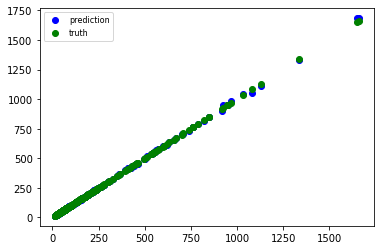

In [13]:
import pandas as pd
import numpy as np
from pandas.tseries.frequencies import to_offset


def align_outputs(y_predicted, X_trans, X_test, y_test, target_column_name,
                  predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.

    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """

    if (horizon_colname in X_trans):
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted,
                                horizon_colname: X_trans[horizon_colname]})
    else:
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted})

    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index

    # align original X_test to y_test
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')

    # drop rows where prediction or actuals are nan
    # happens because of missing actuals
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name,
                               predicted_column_name]].notnull().all(axis=1)]
    return(clean)


df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

#from azureml.automl.core._vendor.automl.client.core.common import metrics
from matplotlib import pyplot as plt
from automl.client.core.common import constants

from azureml.automl.runtime.shared.score import scoring
scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))
# use automl metrics module
#scores = metrics.compute_metrics_regression(
 #   df_all['predicted'],
  #  df_all[target_column_name],
   # list(constants.Metric.SCALAR_REGRESSION_SET),
    #None, None, None)

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
#%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

## Closing

At this point you should have a chart like this one in the image below, created wit AutoML and MatplotLib. The results are that good because of the **logQuantity** column, a  data Leakage calculated from que **quantity** column. You can try to run the same experiment without it.

<img src="https://synapselinkdemoworkshop.blob.core.windows.net/synapse-link/cosmosdb/SalesForecastingWithAML-MatplotLib.png" alt="Result"/>

